## Import

In [214]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math
#import PrettyTable

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, addOverflow
from helper_functions import deltaR, deltaPhi, drawCMS

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

## Load ntuples

## Load variables

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = 'v6'
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA

data_path = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+vers+'/'
lumi = 23.02*1000

if data_year == 2022:
    fpath['data'] = data_path + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
    fpath['signal'] = data_path + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    
for k, T in tree.items():
    branch_names = T.keys()

In [3]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

#cut_based = True
#cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterR = {}
cscClusterZ = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpread = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}
cscClusterMet_dPhi = {}

cscClusterNStation = {}
cscClusterDphi = {}
nCscClusters = {}


#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
nDtClusters = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
dtClusterNHitStation1 = {}
dtCluster_match_MB1hits_0p4 = {}
dtCluster_match_MB1hits_0p5 = {}
dtClusterMaxStationRatio = {}
dtClusterMet_dPhi = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}


#L1 plateau
first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}


first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}

#Angular variables
dPhi_csc_csc = {}
dEta_csc_csc = {}
dR_csc_csc = {}
dt_csc_csc = {}
dPhi_csc_dt = {}
dEta_csc_dt = {}
dR_csc_dt = {}

## Settings

In [4]:
category = 0#-1#0
category = 1
#-1: at least 1csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt, 

do_jet_veto = False
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = False
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = False
do_csc_in_time_cut = False
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True
do_L1_plateau = True

plot_string = ""
#plot_string = "_jet_veto"
#plot_string = "_csc_time_spread_cut"
#plot_string = "_csc_in_time_cut"
#plot_string = ""
#plot_string = "_ME_veto"
#plot_string = "_ME_veto_HLT_eta_cut"
#plot_string = "_ME_veto_HLT_eta_cut_at_least_1_cluster"
#plot_string = "_ME_veto_HLT_eta_cut_in_time_cut_at_least_1_cluster"
#plot_string+= "_exactly_1_csc_cluster"

plot_string+= "_exactly_2_csc_clusters_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_MB_veto"

In [5]:
for a in branch_names:
    #if "MB1" in str(a):
    #    print(a)
    if "dtRechitClusterMaxStationRatio" in str(a):
        print(a)
    #if "atio" in str(a):
    #    print(a)

b'dtRechitClusterMaxStationRatio'


In [6]:
for k, T in tree.items():
    tree_keys.append(k)
    #if not k == 'data' and not k[-4:] == '1000':continue
########### SELECTION: CLUSTERS ############
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal')))
    
    sel_csccluster = T.array('cscRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_csccluster = jet_veto_csc
    if do_inverted_jet_veto:
        sel_csccluster = np.logical_not(jet_veto_csc)       

    if do_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, muon_veto_csc)
    if do_inverted_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(muon_veto_csc))    
          
    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    #Time spread cut
    if do_csc_time_spread_cut:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20)
    
    #Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))

    #ME11 and ME12 veto
    ME11_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')==0
    )  

    ME12_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')==0
    )      

       
    
    if do_ME_veto:
        sel_csccluster = np.logical_and(sel_csccluster,
                                    np.logical_and(ME11_veto,ME12_veto)
                                   ) 
    if do_HLT_eta_cut:
        sel_csccluster = np.logical_and(sel_csccluster,sel_trgCluster)
        
        
    sel_dtcluster = T.array('dtRechitClusterSize') >= 0
    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt')) < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))

    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt)
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt)

    MB1_veto = T.array('dtRechitClusterNHitStation1') == 0
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto)
        
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    HLT_CscCluster_Loose = hlt[:,566]
    HLT_CscCluster_Medium = hlt[:,567]
    HLT_CscCluster_Tight = hlt[:,568]
    HLT_L1CSCShower_DTCluster50 = hlt[:,569]
    HLT_L1CSCShower_DTCluster75 = hlt[:,570]

    #Or of the triggers: starting with the CSC ones
    #hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose,np.logical_or(HLT_CscCluster_Medium,HLT_CscCluster_Tight))
    if category==2:
        hlt_sel_ev[k] = HLT_L1CSCShower_DTCluster50
    else:
        hlt_sel_ev[k] = HLT_CscCluster_Loose
     
    
    #sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    #sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = T.array('nLeptons') == 0
    
    #If trigger:
    #We don't have correct trigger emulation in signal at the moment
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)

    #At least one pre-selected csc cluster, always required
    sel_ev[k] = np.logical_and(sel_ev[k],sel_csccluster.sum()>=1)
    
    
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 2)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == -1:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
           
########### BRANCHES ############

    
    dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNHitStation1[k] = T.array('dtRechitClusterNHitStation1')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_MB1hits_0p4[k] = T.array('dtRechitCluster_match_MB1hits_0p4')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_MB1hits_0p5[k] = T.array('dtRechitCluster_match_MB1hits_0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMet_dPhi[k] =  T.array('dtRechitCluster' + cluster_index + 'Met_dPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMaxStationRatio[k] = T.array('dtRechitCluster' + cluster_index + 'MaxStationRatio')[sel_dtcluster][sel_ev[k]][:,:]
        
    cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[sel_csccluster][sel_ev[k]][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[sel_csccluster][sel_ev[k]][:,:]**2 )
    cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMet_dPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Met_dPhi')[sel_csccluster][sel_ev[k]][:,:]
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
        
      
    sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
    sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
       
    sel_jetveto_dt[k] = jet_veto_dt[sel_dtcluster][sel_ev[k]][:,:]
    sel_muonveto_dt[k] = muon_veto_dt[sel_dtcluster][sel_ev[k]][:,:]        

    dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]]
       
    hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
    sel_ev[k] = sel_ev[k][ sel_ev[k] ]

    nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k].astype(float)),where=(nDtClusters[k].astype(float) != 0))

* Study delta phi with met
* Apply at least one csc cluster requirement
* Apply L1 plateau

# L1 plateau

In [26]:
for k in tree_keys:
    first_in_ME11[k] = (cscClusterR[k][:,0]>100)&(cscClusterR[k][:,0]<275) &(abs(cscClusterZ[k][:,0])>580)&(abs(cscClusterZ[k][:,0])<632) 
    first_in_ME12[k] = (cscClusterR[k][:,0]>275)&(cscClusterR[k][:,0]<465) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)
    first_in_ME13[k] = (cscClusterR[k][:,0]>505)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)

    first_in_ME21[k] = (cscClusterR[k][:,0]>139)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>789)&(abs(cscClusterZ[k][:,0])<850)
    first_in_ME22[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>791)&(abs(cscClusterZ[k][:,0])<850)

    first_in_ME31[k] = (cscClusterR[k][:,0]>160)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>915)&(abs(cscClusterZ[k][:,0])<970)
    first_in_ME32[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>911)&(abs(cscClusterZ[k][:,0])<970)

    first_in_ME41[k] = (cscClusterR[k][:,0]>178)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    first_in_ME42[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    
    first_in_plateau_ME11[k] = first_in_ME11[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME21[k] = first_in_ME21[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME31[k] = first_in_ME31[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME41[k] = first_in_ME41[k] & (cscClusterSize[k][:,0]>=500)

    first_in_plateau_ME12[k] = first_in_ME12[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME13[k] = first_in_ME13[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME22[k] = first_in_ME22[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME32[k] = first_in_ME32[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME42[k] = first_in_ME42[k] & (cscClusterSize[k][:,0]>=200)    
    
    first_in_plateau[k] = first_in_plateau_ME11[k] | first_in_plateau_ME12[k] | first_in_plateau_ME13[k] | first_in_plateau_ME21[k] | first_in_plateau_ME22[k] | first_in_plateau_ME31[k] | first_in_plateau_ME32[k] | first_in_plateau_ME41[k] | first_in_plateau_ME42[k]
    
   
    sel_ev[k] = np.logical_and(sel_ev[k],first_in_plateau[k])
    
    if category==1:
        dPhi_csc_csc[k] = ( deltaPhi(  cscClusterPhi[k][:,0].flatten(), cscClusterPhi[k][:,1].flatten() ) )
        dEta_csc_csc[k] = (  cscClusterEta[k][:,0].flatten() - cscClusterEta[k][:,1].flatten() )
        dR_csc_csc[k]   = deltaR( cscClusterEta[k][:,0].flatten(), cscClusterPhi[k][:,0].flatten(), cscClusterEta[k][:,1].flatten(), cscClusterPhi[k][:,1].flatten() )
        dt_csc_csc[k]   = (  cscClusterTime[k][:,0].flatten() - cscClusterTime[k][:,1].flatten() )
        min_dphi = 0.65
        sel_ev[k] = np.logical_and(sel_ev[k],np.abs(dPhi_csc_csc[k])>min_dphi)
    if category==2:
        dPhi_csc_dt[k] = ( deltaPhi(  cscClusterPhi[k][:,0].flatten(), dtClusterPhi[k][:,0].flatten() ) )
        dEta_csc_dt[k] = (  cscClusterEta[k][:,0].flatten() - dtClusterEta[k][:,0].flatten() )
        dR_csc_dt[k]   = deltaR( cscClusterEta[k][:,0].flatten(), cscClusterPhi[k][:,0].flatten(), dtClusterEta[k][:,0].flatten(), dtClusterPhi[k][:,0].flatten() )

## Study delta phi met-clusters

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

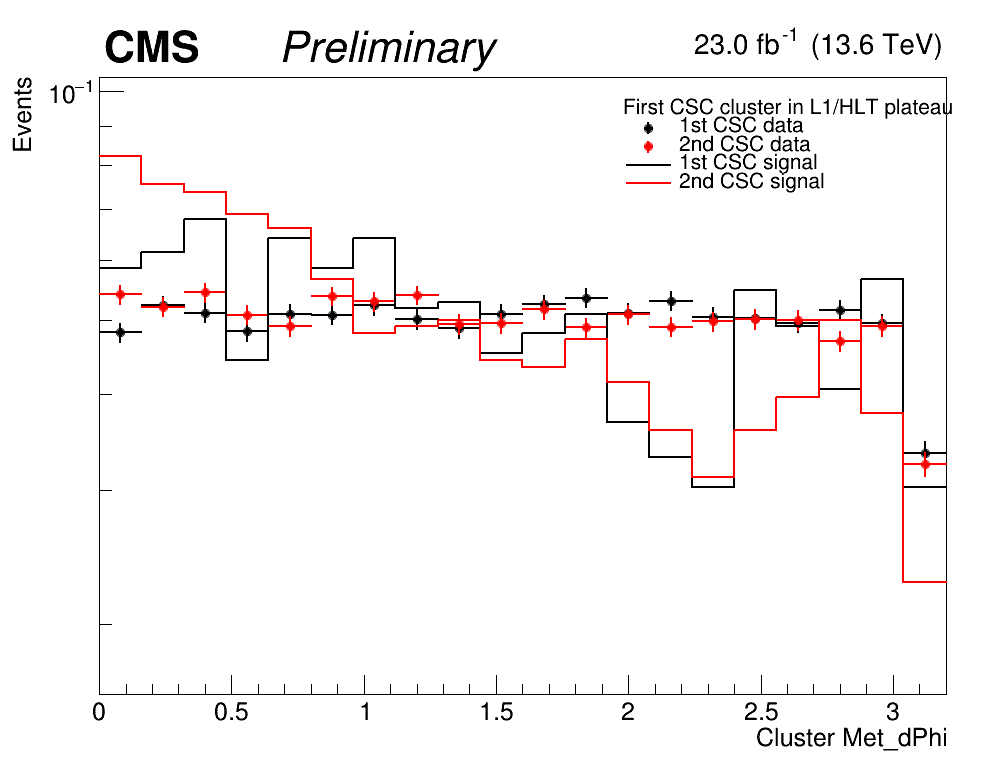

In [27]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.5,0.75,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
scale=False
scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        cut = sel_ev[k]
        h1[k] = create_TH1D(np.abs(cscClusterMet_dPhi[k][ cut ][:,0].flatten()),title="",axis_title = ['Cluster Met_dPhi','Events'], binning=[20,0,3.2])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        
        h0[k] = create_TH1D(np.abs(cscClusterMet_dPhi[k][ cut ][:,1].flatten()),title="",axis_title = ['Cluster Met_dPhi','Events'], binning=[20,0,3.2])
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
        if not scale:
            h0[k].SetMinimum(0.8)
            h1[k].SetMinimum(0.8)
        if 'data' in k:
            h0[k].Draw('PE same')
            h1[k].Draw('PE same')
            leg.AddEntry(h0[k],"1st CSC data","PE")
            leg.AddEntry(h1[k],"2nd CSC data","PE")
        else:
            h0[k].Draw('HISTO same')
            h1[k].Draw('HISTO same')
            leg.AddEntry(h0[k],"1st CSC signal","L")
            leg.AddEntry(h1[k],"2nd CSC signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CscCscMet_dPhi_in_plateau"+lab+plot_string+".pdf")
can.Print("plots/V1p19_"+vers+"/CscCscMet_dPhi_in_plateau"+lab+plot_string+".png")
#can.Close()        

## Signal 2D plot

data
signal


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

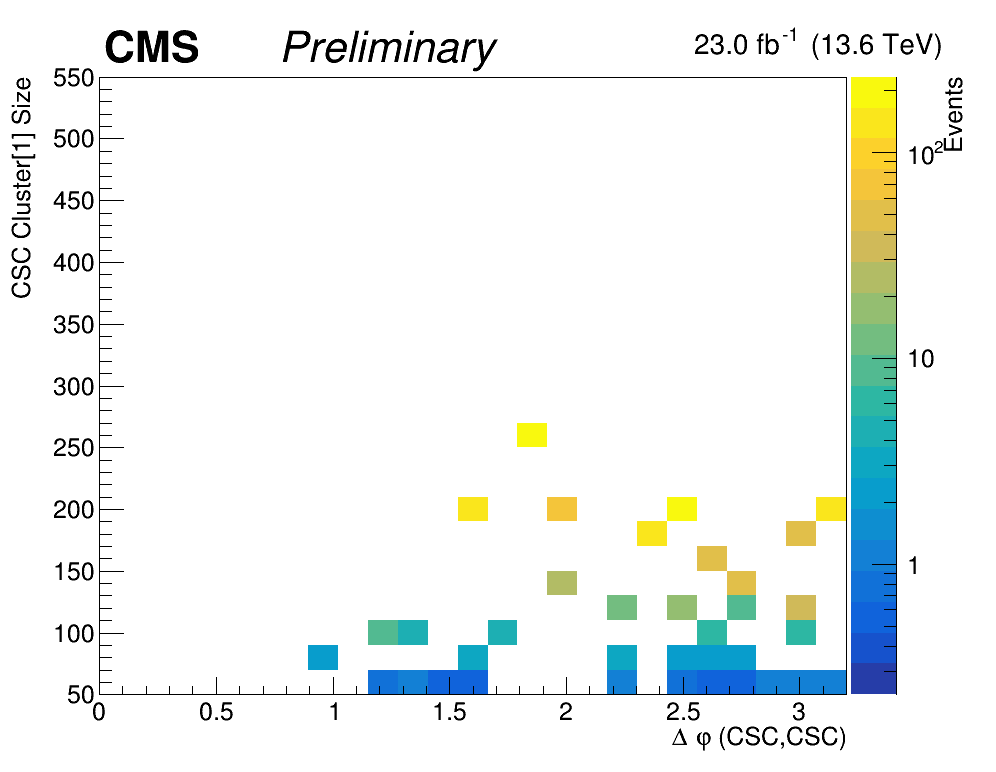

In [75]:
if category==1:

    h2 = {}
    for k in tree_keys:
        print(k)
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.65,0.65,0.88)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        
        can.cd()
        cut = sel_ev[k] & ( np.abs(dEta_csc_csc[k])>2 )
        x_val = np.abs( deltaPhi(  cscClusterPhi[k][cut][:,0].flatten(), cscClusterPhi[k][cut][:,1].flatten() ) )
        y_val = cscClusterSize[k][ cut ][:,1]
        h2[k] = create_TH2D(np.vstack((x_val, y_val)).T,title="",axis_title = ['#Delta #varphi (CSC,CSC)','CSC Cluster[1] Size','Events'], binning=[25,0,3.2,25,50,550])
        leg.SetHeader('CSC-CSC, presel.'+k)
        #h2[k].SetMaximum(100)
        #if 'signal' in k:
        h2[k].Scale(1./h2[k].Integral())
        h2[k].Draw("colz")
        
        leg.Draw()
        can.SetRightMargin(0.15)
        # if setlog: 
        can.SetLogz()
        can.Draw()
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
        can.Print("plots/V1p19_"+vers+"/ABCD_plane_"+str(k)+plot_string+".pdf")
        can.Print("plots/V1p19_"+vers+"/ABCD_plane_"+str(k)+plot_string+".png")
        #can.Close()
        
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    can.cd()
    leg.Draw()
    can.SetRightMargin(0.15)
    h2['signal'].Divide(h2['data'])
    h2[k].Draw("colz")
    can.SetLogz()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+vers+"/ABCD_plane_ratio"+plot_string+".pdf")
    can.Print("plots/V1p19_"+vers+"/ABCD_plane_ratio"+plot_string+".png")
    #can.Close()

## OOT control region

* Beam Halo clusters are smaller (less hits) --> can't claim IT and OOT have the same shape
* Also can't claim small/large dEta have the same shape
* small/large dPhi are more similar instead

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

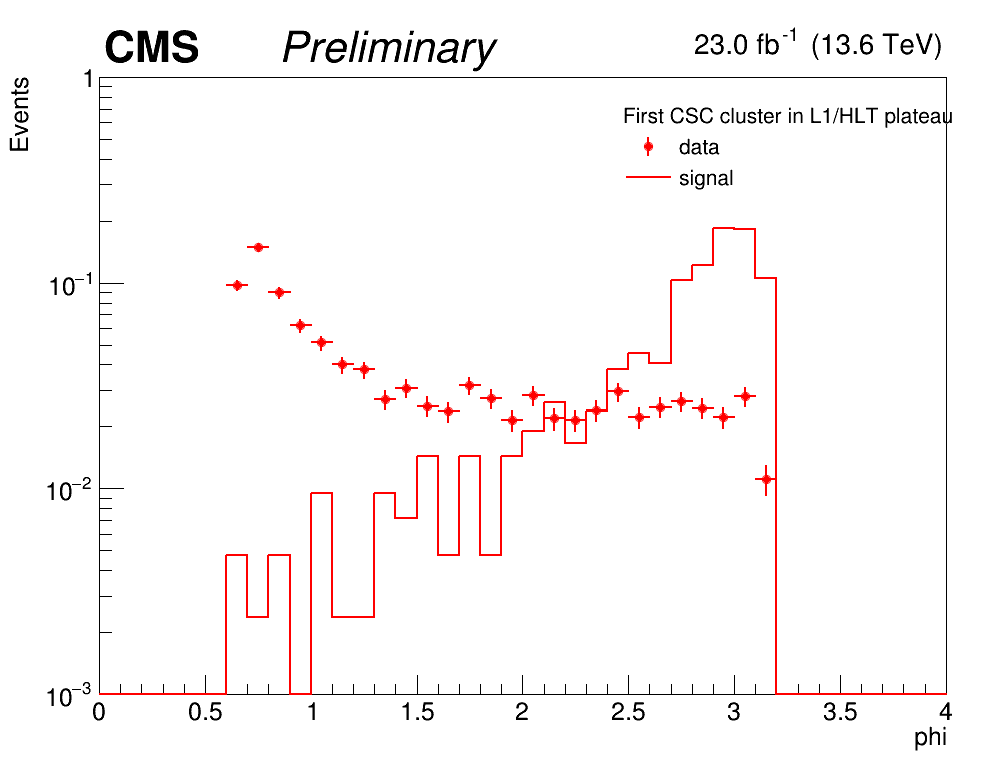

In [111]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.5,0.75,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
scale=False
scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        cut = sel_ev[k]
        h1[k] = create_TH1D(np.abs(dPhi_csc_csc[k][sel_ev[k] & ( np.abs(dEta_csc_csc[k])<0.3 )]),title="",axis_title = ['phi','Events'], binning=[40,0,4])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        
        if not scale:
            h1[k].SetMinimum(0.8)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/test_in_plateau"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/test_in_plateau"+lab+plot_string+".png")
#can.Close()        

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

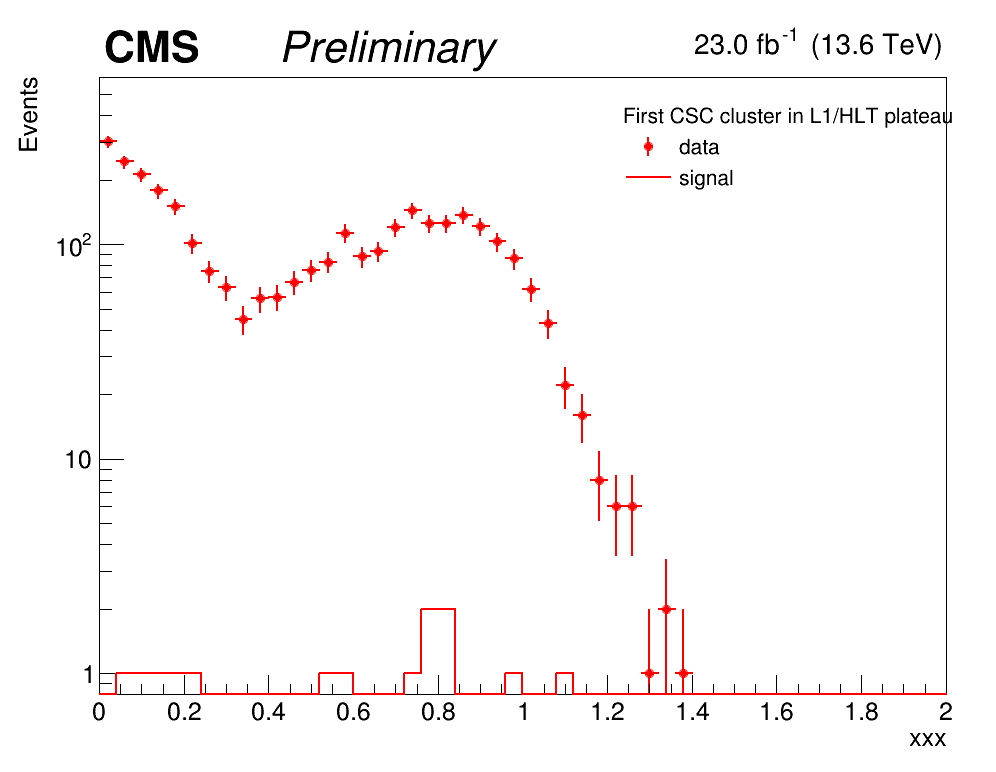

In [103]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.5,0.75,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        cut = sel_ev[k]
        h1[k] = create_TH1D( np.abs(dEta_csc_csc[k][sel_ev[k] & ( np.abs(dEta_csc_csc[k])<2 ) & ( np.abs(dPhi_csc_csc[k])<1 )]),title="",axis_title = ['xxx','Events'], binning=[50,0,2])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        
        if not scale:
            h1[k].SetMinimum(0.8)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/test_in_plateau"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/test_in_plateau"+lab+plot_string+".png")
#can.Close()        

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

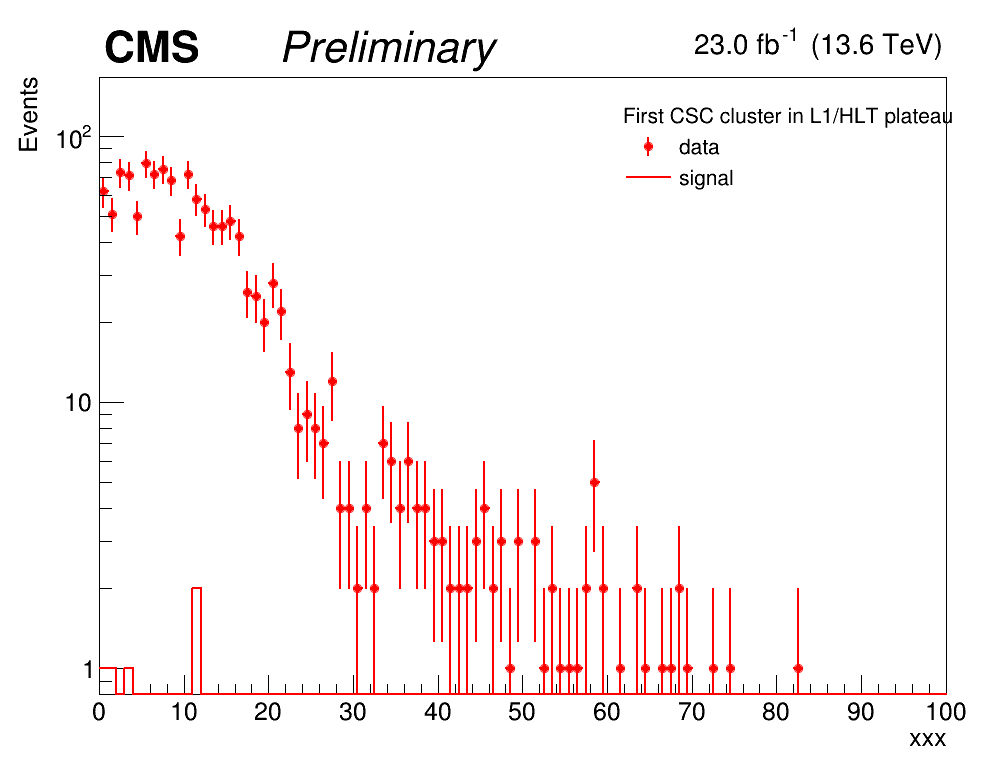

In [110]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.5,0.75,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
scale=False
#scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        cut = sel_ev[k]
        h1[k] = create_TH1D( np.abs(dt_csc_csc[k][sel_ev[k] & (np.abs(dEta_csc_csc[k])<0.3) & (np.abs(dPhi_csc_csc[k])<1) ]),title="",axis_title = ['xxx','Events'], binning=[100,0,100])
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        
        if not scale:
            h1[k].SetMinimum(0.8)
        else:
            h1[k].SetMaximum(1)
            h1[k].SetMinimum(0.001)
        if 'data' in k:
            h1[k].Draw('PE same')
            leg.AddEntry(h1[k],"data","PE")
        else:
            h1[k].Draw('HISTO same')
            leg.AddEntry(h1[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

#print("??")
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/test_in_plateau"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/test_in_plateau"+lab+plot_string+".png")
#can.Close()        

## ABCD based on delta phi

Decided to drop it because of too much beam halo

## ABCD based on time/eta

Large eta
* At large eta (>2) we have stuff mostly OOT or with a large delay. 
* At eta >2, we can validate based on large/small time delay (20). The shapes agree with each othe, can be used as validation.
* At eta>2, phi is flat. Can use that as well as validation. Works well with phi 1.7, 2, 2.7. Very good

Small eta, small phi
* At small eta (<2) and phi<2 must be careful with unblinding
* Time windows agree up to ~30 ns. Beyond that, beam halo components start to dominate

Small eta, very small phi
* At small eta (<2) and even smaller phi<1 can choose in time
* 0-10 and 10-20 agree well

Explore eta feature at 0.3 (probably trigger clustering)
* At 0.3<eta<2 and phi<1, tiny bit of signal left
* Time windows agree up to ~30 ns. Beyond that, beam halo components start to dominate

Explore eta feature < 0.3 (probably trigger clustering)
* At eta<0.3 and phi<1, not much signal left
* Time windows are a bit more unstable, probably not very good for closure. Works only for smaller multiplicities


[ 50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170. 180.
 190. 200. 210. 220. 230. 240. 250. 260. 270. 280. 290. 300. 310. 320.
 330. 340. 350. 360. 370. 380. 390. 400. 410. 420. 430. 440. 450. 460.
 470. 480. 490. 500. 510. 520. 530. 540. 550.]
[ 55.  65.  75.  85.  95. 105. 115. 125. 135. 145. 155. 165. 175. 185.
 195. 205. 215. 225. 235. 245. 255. 265. 275. 285. 295. 305. 315. 325.
 335. 345. 355. 365. 375. 385. 395. 405. 415. 425. 435. 445. 455. 465.
 475. 485. 495. 505. 515. 525. 535. 545.]
-0.025050715302663604 0.0014550834746324987
192.3595142041689 0.0014550834746324987
0.003089843253852505 0.0014550834746324987
x  pred  up down true 
75.0 547.3648990623935 557.9711930469473 574.5888503637005 566.0
x  pred  up down true 
85.0 315.0930853038321 320.66116051711555 331.31909758711237 300.0
x  pred  up down true 
95.0 193.28095086995933 197.03923320441345 202.88058228379955 201.0
x  pred  up down true 
105.0 124.0638141050533 127.00610721790858 129.6823096153096 131.0

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

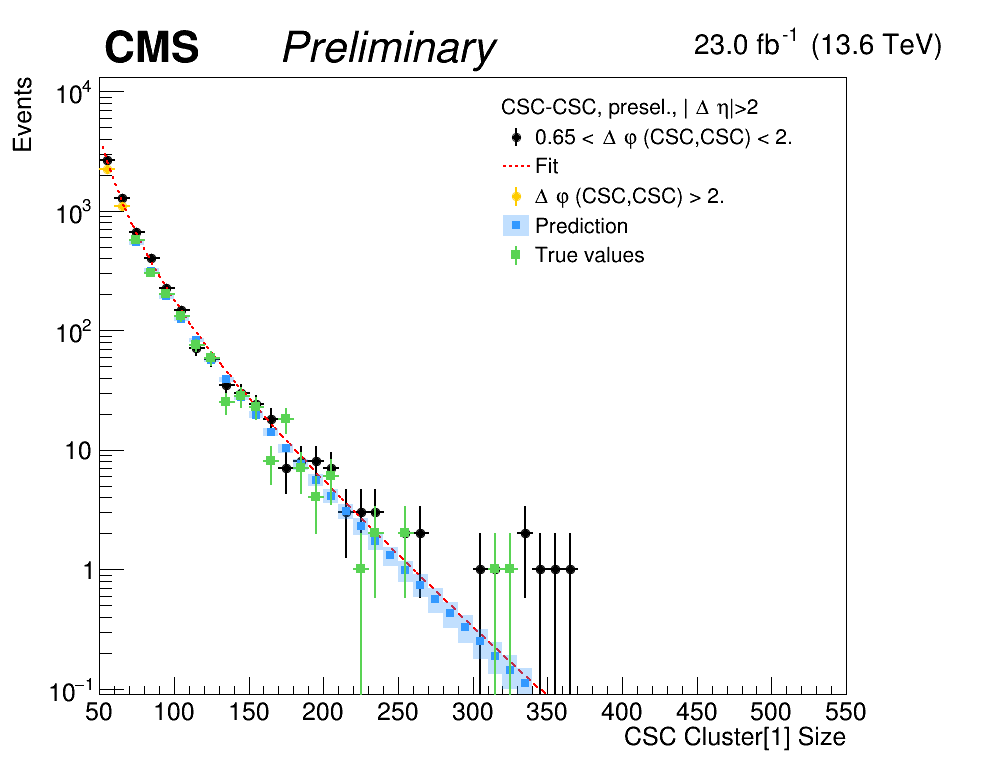

In [229]:
if category == 1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    hnot = {}
    hunbl = {}
    hpred= {}
    can.cd()
    
    x_min = 50
    x_max = 100#1050
    n_bins = 10
    
    #Tune
    x_max = 250
    n_bins = 10
    

    #Tune
    x_max = 550
    n_bins = 10
    
    n_bins = 50

    #Tune
    #x_max = 1050
    #n_bins = 10
    
    #f1 = rt.TF1("f1","expo(-x/([0]+[1]*x))",50,1000)
    #f1 = rt.TF1("f1","expo(-x/(100+50000*x))",50,1000)
    #f1 = rt.TF1("f1","exp(-x/(0*100 + 0*x))",50,1000)
    #f1 = rt.TF1("f1","exp(-1.7*x/(100.) + 0.01/x)",50,550)
    f1 = rt.TF1("f1","exp([0]*x + [1]/(x))/[2]",x_min,x_max)
    #f1 = rt.TF1("f1","exp(-x/([0] + [1]*x))",50,550)
    f1.SetParameter(0,-0.03)
    f1.SetParameter(1,200)
    f1.SetParameter(2,74)
    foot = rt.TF1("foot","exp([0]*x + [1]/(x))/[2]",x_min,x_max)
    foot.SetParameter(0,-0.0069210997892010535)
    foot.SetParameter(1,426.659535750436)
    foot.SetParameter(2,195.1699385925665)
    #e^{-x/(a+bx)
    bins = np.array([  50. , 130. , 210. , 290. , 370. , 450. , 530. , 610. , 690. , 770. , 850. , 930. , 1010. , 1090. , 
                     1170. , 1250. , 1330. , 1410. , 1490. , 1570. , 1650. , 1730. , 1810. , 1890. , 1970. , 2050.])
    #bins = np.array([  50. , 150. , 200. , 250., 300., 400. , 450. , 550. , 700. , 900. , 1500. , 2050.])
    bins = np.linspace(x_min,x_max,n_bins+1)
    bins_center = bins[0:-1]+0.5*(x_max-x_min)/n_bins
    print(bins)
    print(bins_center)
    
    blinding_bin = 2
    
    scale = True
    scale = False
    do_blind = True
    
    x_pred = []
    x_pred_unc = []
    y_pred = []
    y_pred_up = []
    y_pred_down = []
    y_pred_unc = []

    for k in tree_keys:
        tmp_dphi = np.abs( dPhi_csc_csc[k] )
        tmp_deta = np.abs(  dEta_csc_csc[k] )
        tmp_dt = np.abs( dt_csc_csc[k] )
        
        #cut_t = #(np.abs(cscClusterTime[k][:,1])>=0)#50)
        cut_phi = (tmp_dphi<2.)
        #cut_phi_not = (tmp_dphi<0.4) & (tmp_dphi>=0.2)
        #cut_eta = (tmp_deta>=1.2)
        cut_dt = (tmp_dt>=20)
        blind = (cscClusterSize[k][:,1] < bins[blinding_bin] if do_blind else 100000 )
        unblind = (cscClusterSize[k][:,1] >= bins[blinding_bin])
        
        #Works very well:
        '''
        leg.SetHeader('CSC-CSC, presel., |#Delta #eta|>2')
        pre_cut = sel_ev[k] & (tmp_deta>2)
        cut = (cut_dt==True)
        cut_label = "#Delta t (CSC,CSC) #geq 20 ns"
        cut_not = (cut_dt==False)
        cut_not_label = "#Delta t (CSC,CSC) < 20 ns"
        '''
        
        #Works very well:
        
        leg.SetHeader('CSC-CSC, presel., |#Delta #eta|>2')
        pre_cut = sel_ev[k] & (tmp_deta>2.)
        cut = (cut_phi==True)
        cut_label = "0.65 < #Delta #varphi (CSC,CSC) < 2."
        cut_not = (cut_phi==False)
        cut_not_label = "#Delta #varphi (CSC,CSC) > 2."
        
        
        #Works with care, beyond dt~30 s distribution shape changes
        '''
        leg.SetHeader('CSC-CSC, presel., |#Delta #eta|<2, |#Delta #varphi|<2')
        pre_cut = sel_ev[k] & (tmp_deta<2.) & (tmp_dphi<2.)
        cut_dt_small = (tmp_dt>=0) & (tmp_dt<10)
        cut_dt_large = (tmp_dt>=10) & (tmp_dt<20) 
        cut = (cut_dt_large==True)
        cut_label = "#Delta t (CSC,CSC) > 20"
        cut_not = (cut_dt_small==True)
        cut_not_label = "15<#Delta t (CSC,CSC)<20"  
        '''

        #Works with care, beyond dt~30 s distribution shape changes
        '''
        leg.SetHeader('CSC-CSC, presel., |#Delta #eta|<2, |#Delta #varphi|<1')
        pre_cut = sel_ev[k] & (tmp_deta<2.) & (tmp_dphi<1.)
        cut_dt_small = (tmp_dt>=0) & (tmp_dt<10)
        cut_dt_large = (tmp_dt>=10) & (tmp_dt<30) 
        cut = (cut_dt_large==True)
        cut_label = "#Delta t (CSC,CSC) > 20"
        cut_not = (cut_dt_small==True)
        cut_not_label = "15<#Delta t (CSC,CSC)<20"  
        '''

        '''
        leg.SetHeader('CSC-CSC, presel., 0.3<|#Delta #eta|<2, |#Delta #varphi|<1')
        pre_cut = sel_ev[k] & (tmp_deta>=0.3) & (tmp_deta<2.) & (tmp_dphi<1.)
        cut_dt_small = (tmp_dt>=0) & (tmp_dt<10)
        cut_dt_large = (tmp_dt>=10) & (tmp_dt<25) 
        cut = (cut_dt_large==True)
        cut_label = "#Delta t (CSC,CSC) > 20"
        cut_not = (cut_dt_small==True)
        cut_not_label = "15<#Delta t (CSC,CSC)<20"
        '''

        '''
        leg.SetHeader('CSC-CSC, presel., |#Delta #eta|<0.3, |#Delta #varphi|<1')
        pre_cut = sel_ev[k] & (tmp_deta<0.3) & (tmp_dphi<1.)
        cut_dt_small = (tmp_dt>=0) & (tmp_dt<12)
        cut_dt_large = (tmp_dt>=12) & (tmp_dt<20) 
        cut = (cut_dt_large==True)
        cut_label = "#Delta t (CSC,CSC) > 20"
        cut_not = (cut_dt_small==True)
        cut_not_label = "15<#Delta t (CSC,CSC)<20" 
        '''
        
        csc_size_2 = cscClusterSize[k][ pre_cut & cut ][:,1]
        csc_size_2_not = cscClusterSize[k][ pre_cut & cut_not & blind ][:,1]
        csc_size_2_unbl = cscClusterSize[k][ pre_cut & cut_not & unblind ][:,1]
        h[k] = create_TH1D(csc_size_2.flatten(),title="",axis_title = ['CSC Cluster[1] Size','Events'], binning=bins,bin_list=True)
        #addOverflow(h[k])
        
        h[k].SetLineColor(1)
        h[k].SetLineWidth(2)
        h[k].SetMarkerColor(1)
        h[k].SetMarkerStyle(20)
        h[k].SetMarkerSize(1.2)
        
        #hpred[k] = TH1F("pred_"+k,"pred_"+k,len(bins)-1, array('f',bins))
        #hpred[k].Sumw2()
        
        hnot[k] = create_TH1D(csc_size_2_not.flatten(),title="",axis_title = ['CSC Cluster[1] Size','Events'], binning=bins,bin_list=True)
        hnot[k].SetLineColor(800)
        hnot[k].SetLineWidth(2)
        hnot[k].SetMarkerColor(800)
        hnot[k].SetMarkerStyle(20)
        hnot[k].SetMarkerSize(1.2)
        
        hunbl[k] = create_TH1D(csc_size_2_unbl.flatten(),title="",axis_title = ['CSC Cluster[1] Size','Events'], binning=bins,bin_list=True)
        hunbl[k].SetLineColor(8)
        hunbl[k].SetLineWidth(2)
        hunbl[k].SetMarkerColor(8)
        hunbl[k].SetMarkerStyle(21)
        hunbl[k].SetMarkerSize(1.2)
        if scale:
            h[k].Scale(1./h[k].Integral() if h[k].Integral()>0 else 1.)
            hnot[k].Scale(1./hnot[k].Integral() if hnot[k].Integral()>0 else 1.)
            hunbl[k].Scale(1./hunbl[k].Integral() if hunbl[k].Integral()>0 else 1.)
            
        h[k].SetMaximum(  5*max(1. if scale else 1.9, max(h[k].GetMaximum(),hnot[k].GetMaximum()) )  )        
        min_y = max(max(h[k].GetMinimum(),1.e-500 if scale else 0.9), max(hnot[k].GetMinimum(),1.e-500 if scale else 0.9))
        h[k].SetMinimum(min_y*0.1)        
        
        if 'data' in k:
            
            h[k].Fit('f1', 'LRSQ+', '', x_min,x_max)
            my_f1 = h[k].GetFunction("f1")            
            h[k].GetListOfFunctions().Remove(h[k].GetFunction("f1"))
            print(my_f1.GetParameter(0),my_f1.GetParError(0))
            print(my_f1.GetParameter(1),my_f1.GetParError(0))
            print(my_f1.GetParameter(2),my_f1.GetParError(0))
            my_f1_up = my_f1.Clone("my_f1_up")
            my_f1_down = my_f1.Clone("my_f1_down")
            my_f1_up.SetParameter(0,  my_f1.GetParameter(0) + my_f1.GetParError(0) )
            my_f1_up.SetParameter(1,  my_f1.GetParameter(1) + my_f1.GetParError(1) )
            my_f1_up.SetParameter(2,  my_f1.GetParameter(2) + my_f1.GetParError(2) )
            my_f1_down.SetParameter(0,  my_f1.GetParameter(0) - my_f1.GetParError(0) )
            my_f1_down.SetParameter(1,  my_f1.GetParameter(1) - my_f1.GetParError(1) )
            my_f1_down.SetParameter(2,  my_f1.GetParameter(2) - my_f1.GetParError(2) )
            #print(foot.GetParameter(0))
            #print(foot.GetParameter(1))
            #print(foot.GetParameter(2))
            h[k].Draw("PE same")
            hnot[k].Draw("PE same")
            my_f1.SetLineStyle(2)
            my_f1.Draw('L same')
            
            leg.AddEntry(h[k],cut_label,"PE")
            leg.AddEntry(my_f1,"Fit","L")
            leg.AddEntry(hnot[k],cut_not_label,"PE")
            
            if not do_blind:
                hnot[k].Fit('foot', 'LRSQ+', '', x_min,x_max)
                my_foot = hnot[k].GetFunction("foot")
                hnot[k].GetListOfFunctions().Remove(hnot[k].GetFunction("foot"))
                my_foot.SetLineColor(4)
                my_foot.Draw('L same')
                leg.AddEntry(my_foot,"Fit","L")
                
            else:
                ratio = hnot[k].Integral(1,blinding_bin)/h[k].Integral(1,blinding_bin)
                #print("hnot ",ratio)
                #print("prediction:")
                my_f1_up.SetLineColor(4)
                my_f1_down.SetLineColor(1)
                #my_f1_up.Draw("L same")
                #my_f1_down.Draw("L same")
                for b in bins_center[blinding_bin:]:
                    print("x ", "pred ", "up", "down", "true ")
                    print(b,ratio*my_f1.Eval(b), ratio*my_f1_up.Eval(b), ratio*my_f1_down.Eval(b),  hunbl[k].GetBinContent(hunbl[k].FindBin(b)))
                    x_pred.append(b)
                    x_pred_unc.append(0.5*(x_max-x_min)/n_bins)
                    y_pred.append(ratio*my_f1.Eval(b))
                    y_pred_up.append(ratio*my_f1_up.Eval(b))
                    y_pred_down.append(ratio*my_f1_down.Eval(b))
                    y_pred_unc.append(max( abs(ratio*my_f1.Eval(b) - ratio*my_f1_up.Eval(b)) , abs(ratio*my_f1.Eval(b) - ratio*my_f1_down.Eval(b)) ))
                
                
                gr = create_TGraph(x_pred,y_pred,ex=x_pred_unc,ey=y_pred_unc, axis_title = ['',''])
                #print(gr.Print())
                gr.SetFillColorAlpha(861,0.3)
                gr.SetLineColor(861)
                gr.SetLineWidth(0)
                gr.SetMarkerStyle(21)
                gr.SetMarkerColor(861)

                gr.Draw('PE2 same')
                leg.AddEntry(gr,"Prediction","PF")
                hunbl[k].Draw('PE same')
                leg.AddEntry(hunbl[k],"True values","PE")
                
        #if 'signal' in k:
        #    h[k].Draw("HISTO same")
        #    hnot[k].Draw("HISTO same")            
            
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    can.Print("plots/V1p19_"+vers+"/CscCscClusterSize_fit_test"+plot_string+".pdf")
    can.Print("plots/V1p19_"+vers+"/CscCscClusterSize_fit_test"+plot_string+".png")
    print("\n")
    
    print("\n")
    #can.Close()

# ABCD

In [230]:
PHI_MIN = min_dphi
PHI_CUT = 2
MIN_N = 90
MAX_N = 250
a = {}
b = {}
c = {}
d = {}
if category==1:
    for k in tree_keys:
        if 'data' in k:
            #A: SR
            #C: all low, black first bins
            #B: yellow
            #D: black high bins
            d[k] = h[k].Integral(blinding_bin+1,n_bins)
            b[k] = hnot[k].Integral(0,blinding_bin)
            c[k] = h[k].Integral(0,blinding_bin)
            a[k] = hunbl[k].Integral()
    
            pred = (b[k]*d[k])/c[k]
            unc_pred = (1./b[k] + 1./d[k] + 1./c[k])**0.5*pred
            print("B\t", "C\t", "D\t", "A pred (B*D/C)\t", "Graph \t\t", "A true")
            print( ("%i\t %i\t %i\t %.2f +- %.2f %.2f +- %.2f %i") % (b[k],c[k],d[k],pred,unc_pred,np.sum(y_pred),np.sqrt( np.sum(np.array(y_pred_unc)**2)),a[k]))

B	 C	 D	 A pred (B*D/C)	 Graph 		 A true
3337	 3918	 1715	 1460.68 +- 49.27 1458.64 +- 33.97 1459


## Effect of CSC being in more than one station

Look at smoothness of DT

* Check if HLT bit is correct
* Split in different CSC categories --> there are kinks...